<a href="https://colab.research.google.com/github/abyki/reprotech-2021-2022/blob/main/NLG-%D0%A25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers
!pip install sentencepiece

In [6]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [7]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [8]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])

Немного обрежем данные

In [9]:
train_df=train_df.iloc[  :35000,:]

In [10]:
train_df=train_df.sample(frac = 1)

In [11]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [12]:
num_of_batches=int(num_of_batches)

Проверка наличия GPU

In [13]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Загрузим обученную модель и токенайзер

In [14]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

## Инициализируем оптимизатор Adafactor с рекомендуемыми для T5 параметрами

In [15]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

  






In [16]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [17]:
num_of_epochs=1

## Транировка модели

In [18]:

model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)
 
    optimizer.zero_grad()

    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    loss.backward()

    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.4979317506296294


## Лосс по времени

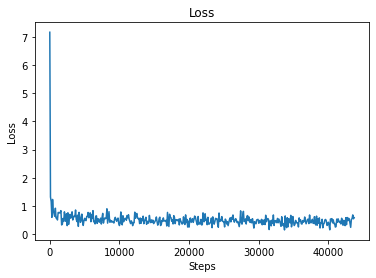

In [19]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Тестировка модели

In [20]:
model.eval()
input_ids = tokenizer.encode("WebNLG: student | hometown | Moscow && student | play |  football </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad> Moscow is the hometown of student, who play football.</s>'

Для начала научимся версионализировать модели и загружать их
Это хорошая практика для работы 

In [21]:
torch.save(model.state_dict(),'pytoch_model.bin')

In [22]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2022-05-19 21:40:05--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.133.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.133.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json.1’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2022-05-19 21:40:05 (69.3 MB/s) - ‘t5-base-config.json.1’ saved [1199/1199]



Имея сохраненную модель и базовый конфиг, мы можем загрузить модель для дальнейшей работы

In [23]:
model = T5ForConditionalGeneration.from_pretrained('pytoch_model.bin', return_dict=True,config='t5-base-config.json')

Наконец перейдем к тестировки модели, поиграемся немного

In [24]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [25]:
generate('Real Madrid | wins | Champions_league')

Generated in 0.60 seconds


' Real Madrid won the Champions League.'

In [37]:
generate('Ivanov | profession | Doctor  && Ivanov | home_town |  Ivanovo')

Generated in 1.13 seconds


' Ivanovo is home to Ivanov, a doctoral doctor.'

In [27]:
generate('notebook | owner | Mugadzhir')

Generated in 1.15 seconds


' Mugadzhir is the owner of the book, which is owned by Mugad'

In [42]:
generate('Akaev | make_food | very_bad')

Generated in 1.27 seconds


' Akaev is a dish that makes a very bad food.'

In [29]:
generate('stage | activate_prepare | script')

Generated in 0.87 seconds


' The script is the script for the active preparation of the stage.'

Попробуем квантизировать нашу модель и сравнить результаты

In [30]:
import torch.quantization
import torch.nn as nn

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)

In [31]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 891.728959
Size (MB): 322.018489


Видим разницу в размере модели после квантирования

In [32]:
def quant_generate(text):
  quantized_model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = quantized_model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [33]:
quant_generate('VK | CEO | Durov  && VK | number Of Employees | 52000 ')

Generated in 0.74 seconds


' The CEO of VK is Durov and there are 52000 people.'

In [34]:
generate('VK | CEO | Durov  && VK | number Of Employees | 52000 ')

Generated in 1.10 seconds


' VK, which has 52000 employees, has a CEO named Durov.'

In [43]:
quant_generate('Akaev | make_food | very_bad')

Generated in 1.13 seconds


' AKAev is a dish made of a very bad food.'

In [44]:
quant_generate('Real Madrid | wins | Champions_league')

Generated in 1.48 seconds


' The champions league of Real Madrid are the winners of the league.'

In [45]:
quant_generate('Ivanov | profession | Doctor  && Ivanov | home_town |  Ivanovo')

Generated in 1.56 seconds


' The doctoral Ivanov, whose profession is Doctor, is a doctor in I'

In [46]:
quant_generate('notebook | owner | Mugadzhir')

Generated in 1.32 seconds


' The owner of the book, The Mugadzhir, is the owner of the note'

In [47]:
quant_generate('stage | activate_prepare | script')

Generated in 1.23 seconds


' The script is the script of the stage, which is the stage of the activation.'